# 2D Neural Style Transfer

This is the Jupyter Notebook for 2D neural style transfer. The goal is to transfer style from one image onto another.


In its traditional form, neural style transfer requires 3 images as input: a style image, a content image and an input image. The input image is often a clone of content image or a white noise image. In some simplified version, the pipeline would ignore content loss and only consume 2 images as input, namely a style image and an input image. In this case, the input image has to be clone of content image.


A very interesting task related to neural style transfer is style reconstruction. This is done by ignoring content loss and content image. The input image is just white noise in case of style reconstruction. In this notebook, this is done by setting the variable ***need_content*** to False.


This notebook can be directly run on Google Colab without additional effort. For acceleration it is helpful to use a GPU runtime.

## Step 0: imports

In [ ]:
import sys
import torch

# install KeOps kernels
!pip install -q pykeops==1.4.1 # > install.log

# install pytorch version of np.Interp, which is used for histogram loss
!pip install -q git+https://github.com/aliutkus/torchinterp1d.git

# Please run the following two lines DEPENDENTLY! (depends on whether the notebook is run locally or on Colab)
!git clone https://github.com/wmd0701/MA.git NST
%cd NST

# import self-defined functions
from utils.data_loader import image_loader, image_unloader
from utils.pipeline import pipeline_2D_NST
from utils.plot import plot_loss

# better plot
%pylab inline

     |████████████████████████████████| 319 kB 5.1 MB/s 
Cloning into 'NST'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 205 (delta 95), reused 147 (delta 39), pack-reused 0
Receiving objects: 100% (205/205), 32.90 MiB | 36.90 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/NST
PyTorch3D not installed! Ignore this message if running 2D NST.
PyTorch3D not installed! Ignore this message if running 2D NST.
PyTorch3D not installed! Ignore this message if running 2D NST.
Populating the interactive namespace from numpy and matplotlib


## Step 1: load images

Following arguments should be considered:


*   **imsize**: resize image, can be int or tuple (int, int). In case an int is given, the image is resized such that its short edge has length of that int while keeping height-width ratio.

*   **tiling**: tile image, can be int or tuple (int, int). In case an int x is given, tiling of (x, x) is conducted.

*   **freq_lower**: frequency threshold for FFT high pass filter.

*   **freq_upper**: frequency threshold for FFT low pass filter.

*   **grayscale**: whether the image should be transformed into grayscale, boolean.

*   **mask**: whether the image is a mask, boolean.

torch.Size([1, 3, 256, 384])


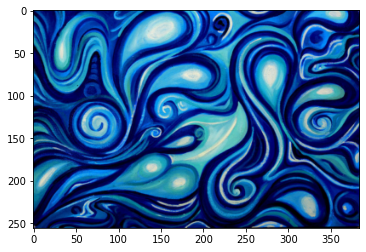

torch.Size([1, 3, 256, 341])


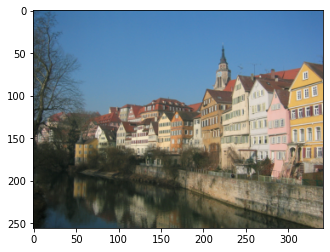

In [ ]:
style_img = image_loader("./image_style/blue_swirls.jpg", imsize=256, tiling=1, freq_lower=None, freq_upper=None)
content_img = image_loader("./image_content/Tuebingen_Neckarfront.jpg", imsize=256)

print(style_img.shape)
imshow(image_unloader(style_img));show()
print(content_img.shape)
imshow(image_unloader(content_img))

## Step 2: run neural style transfer pipeline

Building the style transfer model..


Style model is as follow:
Sequential(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (style_loss_1_1): StyleLoss(
    (mask_layer): GetMask()
  )
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (style_loss_2_1): StyleLoss(
    (mask_layer): GetMask()
  )
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (style_loss_3_1): StyleLoss(
    (mask_layer): GetMask()
  )
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

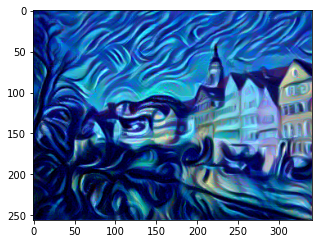

In [ ]:
# style layers and their corresponding weights
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
style_weights = [1e6/n**2 for n in [64,128,256,512]]

# content layer and its weight (normally only one single content layer)
content_layers = ['conv4_2']
content_weights = [1]

# max or avg pooling
model_pooling = 'max'
mask_pooling = 'avg'

# number of optimization iteration and learning rate
n_iters = 200
learning_rate = 1

# !!! whether to ignore content loss or not
need_content = True

# types of applied style losses and their weights
style_loss_types = {#'gram':1,
                    'bnst':1,
                    #'morest':1e-1,
                    #'histo':1,
                    #'linear':1,
                    #'poly':1,
                    #'rbf':1e2,
                    }

# input image tensor
# input_img = torch.rand(style_img.shape, device=input_img.device)
# input_img = torch.rand(content_img.shape, device=content_img.device)
input_img = content_img.clone()

# masking
mask_img = None # image_loader("image_content/sil_cow_grayscale.png", imsize = input_img.shape[-2:], mask = True)
masking = False

# pipeline
output_img, loss_history,style_losses = pipeline_2D_NST(style_img = style_img, 
                                                        content_img = content_img,
                                                        input_img = input_img,
                                                        mask_img = mask_img,
                                                        n_iters = n_iters,
                                                        style_weights = style_weights,
                                                        content_weights = content_weights,
                                                        style_layers = style_layers,
                                                        content_layers = content_layers,
                                                        style_loss_types = style_loss_types,
                                                        learning_rate = learning_rate,
                                                        need_content = need_content,
                                                        masking = masking,
                                                        model_pooling = model_pooling,
                                                        mask_pooling = mask_pooling,
                                                        silent = False)
 

imshow(image_unloader(output_img))
gcf().set_size_inches(5,5)

## Step 3: loss plot

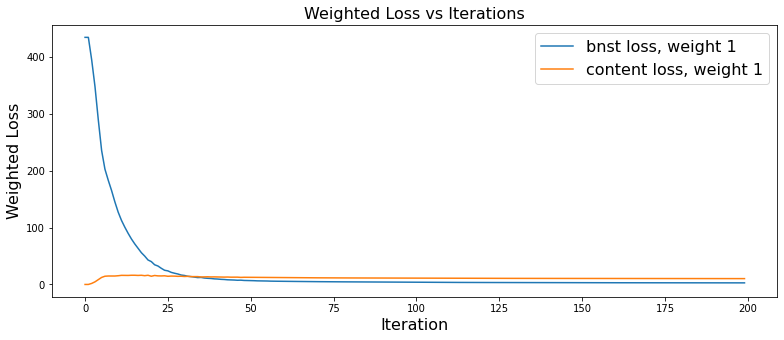

In [ ]:
plot_loss(loss_history, loss_name = None, start = 0, end = n_iters)